In [1]:
import rdkit
from rdkit.Chem import AllChem
import pandas as pd
import os
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina
from rdkit import Chem
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem import Draw
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit import DataStructs

In [2]:
import json
with open('../../sup_info/crossdock2020_duplicated_uniprotId_map_smiles_in_trainset.json','r') as f:
    crossdock2020_duplicated_uniprotId_map_smiles_in_trainset = json.load(f)

In [ ]:

def get_trainset_scaffold(x,ref_map):
    uniprot_id  = x['UniprotID']
    if uniprot_id not in ref_map:
        return []
    else:
        all_find_scaffold = [i[1:-1] for i in x.Finded_Scaffolds[1:-1].split(', ')]
        all_find_scaffold = [Chem.MolToSmiles(Chem.MolFromSmiles(i)) for i in all_find_scaffold if i != '']
        ref_scaffolds = [Chem.MolToSmiles(Chem.MolFromSmiles(i)) for i in ref_map[uniprot_id]['scaffold'] if i != '']
        list_dup_scaffolds = list(set(all_find_scaffold).intersection(set(ref_scaffolds)))
        return list_dup_scaffolds
def get_trainset_smiles(x,ref_map):
    uniprot_id  = x['UniprotID']
    if uniprot_id not in ref_map:
        return []
    else:
        all_find_smiles = [i[1:-1] for i in x.Finded_Smiles[1:-1].split(', ')]
        all_find_smiles = [Chem.MolToSmiles(Chem.MolFromSmiles(i)) for i in all_find_smiles if i != '']
        ref_smiles = [Chem.MolToSmiles(Chem.MolFromSmiles(i)) for i in ref_map[uniprot_id]['smiles'] if i != '']
        list_dup_smiles = list(set(all_find_smiles).intersection(set(ref_smiles)))
    
        return list_dup_smiles
def GetScaffold(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        # 计算分子骨架
        scaffold = MurckoScaffold.GetScaffoldForMol(mol)
        # 输出分子骨架的 SMILES
        scaffold_smiles = Chem.MolToSmiles(scaffold)
        return scaffold_smiles
    except:
        return 'None'
def getFindSmilesNumWithRefScaffold(x):
    all_find_scaffold = [i[1:-1] for i in x.Finded_Scaffolds[1:-1].split(', ')]
    all_find_scaffold = [Chem.MolToSmiles(Chem.MolFromSmiles(i,sanitize = False)) for i in all_find_scaffold if i != '']
    # check generated smiles with finded scaffolds
    all_generated_smiles = [i[1:-1] for i in x.Generated_Smiles[1:-1].split(', ')]
    all_generated_smiles = [Chem.MolToSmiles(Chem.MolFromSmiles(i,sanitize = False)) for i in all_generated_smiles if i != '']
    find_Scaffold_to_smiles = []
    for generated_smiles in all_generated_smiles:
        generated_scaffold = GetScaffold(generated_smiles)
        if generated_scaffold in all_find_scaffold and generated_scaffold != 'None':
            find_Scaffold_to_smiles.append(generated_smiles)
    return len(set(find_Scaffold_to_smiles))


In [5]:

def getScaffoldAndSmiles(all_result_path):
    all_results = os.listdir(all_result_path)
    all_results_pd = []
    for temp_path in all_results:
        model_name = os.path.splitext(temp_path)[0]

        temp_path = os.path.join(all_result_path, temp_path)
        temp_pd = pd.read_csv(temp_path)
        temp_pd['ModelName'] = [model_name]*len(temp_pd)
        all_results_pd.append(temp_pd)
    merged_result_pd = pd.concat(all_results_pd,axis = 0)#['ModelName'].value_counts()
    merged_result_pd['Finded_Scaffolds_To_Smiles_Num'] = merged_result_pd.apply(lambda x: getFindSmilesNumWithRefScaffold(x),axis = 1)
    merged_result_pd['Finded_Smiles_Hit_Rate(%)'] = merged_result_pd['Finded_Smiles_Num'].apply(lambda x: 100*(x/200))
    merged_result_pd['Finded_Scaffold_Hit_Rate(%)'] = merged_result_pd['Finded_Scaffolds_To_Smiles_Num'].apply(lambda x: 100*(x/200))

    return merged_result_pd

In [6]:
all_result_path1 = '/home/data-house-01/cdhofficial/MolGens/TestSample_H2L/Round1/Hit_to_Lead_Results/Hit_Info_Results'
scaffold_molecule_pd1   =  getScaffoldAndSmiles(all_result_path1)
all_result_path2 = '/home/data-house-01/cdhofficial/MolGens/TestSample_H2L/Round1/Hit_to_Lead_Results/Hit_Info_Results'
scaffold_molecule_pd2   =  getScaffoldAndSmiles(all_result_path2)
all_result_path3 = '/home/data-house-01/cdhofficial/MolGens/TestSample_H2L/Round1/Hit_to_Lead_Results/Hit_Info_Results'
scaffold_molecule_pd3   =  getScaffoldAndSmiles(all_result_path3)


In [7]:
data_mean_from_uniprot = pd.concat([scaffold_molecule_pd1,scaffold_molecule_pd2,scaffold_molecule_pd3],axis = 0)[['ModelName','UniprotID','Finded_Smiles_Hit_Rate(%)','Finded_Scaffold_Hit_Rate(%)']].groupby(['ModelName','UniprotID']).agg('mean')

In [8]:
data_mean_from_uniprot.reset_index().to_csv('/home/data-house-01/cdhofficial/MolGens/TestSample_H2L/Round1/Hit_to_Lead_Results/hit2lead_hit_rate_all_protein.csv',index = False)

In [9]:
data_mean_from_uniprot = pd.read_csv('/home/data-house-01/cdhofficial/MolGens/TestSample_H2L/Round1/Hit_to_Lead_Results/hit2lead_hit_rate_all_protein.csv')

In [10]:
color_list = sns.color_palette("Set2", n_colors=7)
# Create a color mapping for each model name
model_names = sorted(data_mean_from_uniprot ['ModelName'].unique().tolist())
color_map = {name: color_list[i % len(color_list)] for i, name in enumerate(model_names)}

In [11]:
data_mean_from_uniprot = data_mean_from_uniprot[['ModelName','UniprotID','Finded_Smiles_Hit_Rate(%)','Finded_Scaffold_Hit_Rate(%)']].groupby(['ModelName','UniprotID']).agg('mean')

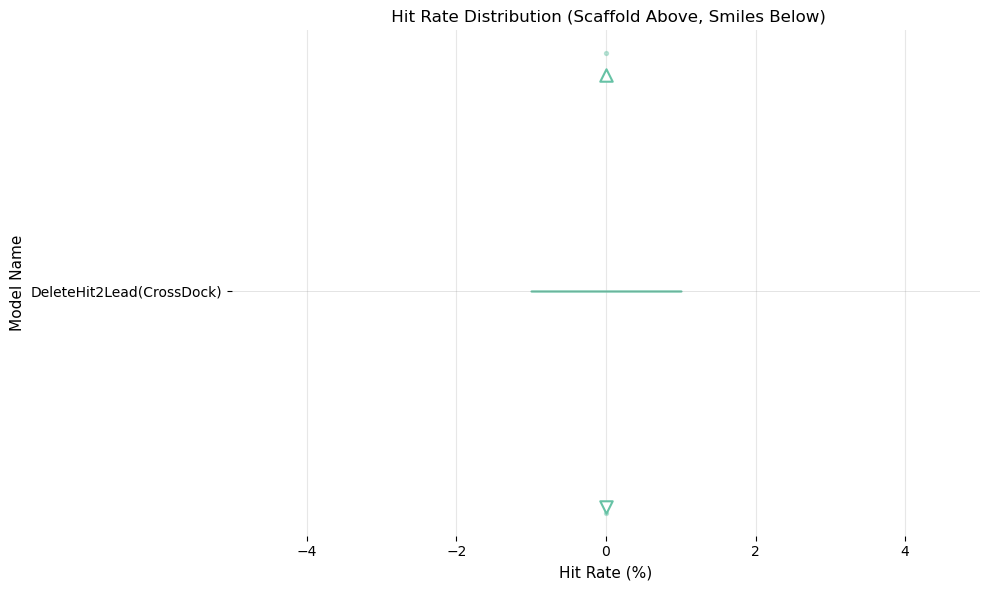

In [12]:
from scipy.stats import gaussian_kde

# Create ridge plotriables based on the context
fig, ax = plt.subplots(figsize=(10, 6))
data_plot = data_mean_from_uniprot.reset_index()
model_order = data_plot.groupby('ModelName')['Finded_Scaffold_Hit_Rate(%)'].mean().sort_values(ascending=True).index
# Prepare data for ridge plot
ridge_spacing = 1.0  # Vertical spacing between ridges
y_positions = np.arange(len(model_order)) * ridge_spacing
scaffold_data = [data_mean_from_uniprot.loc[model]['Finded_Scaffold_Hit_Rate(%)'].values for model in model_order]
smiles_data = [data_mean_from_uniprot.loc[model]['Finded_Smiles_Hit_Rate(%)'].values for model in model_order]
# Create ridge plot for both scaffold and smiles data
for i, model in enumerate(model_order):
    y_base = y_positions[i]
    
    # Get data for current model
    scaffold_values = scaffold_data[i]
    smiles_values = smiles_data[i]
    
    # Create density plots using kernel density estimation
    
    # Scaffold density
    if len(scaffold_values) > 1 and np.std(scaffold_values) > 0:
        kde_scaffold = gaussian_kde(scaffold_values)
        x_range = np.linspace(scaffold_values.min() - 1, scaffold_values.max() + 1, 200)
        density_scaffold = kde_scaffold(x_range)
        # Normalize and scale density
        density_scaffold = density_scaffold / density_scaffold.max() * 0.35
    else:
        x_range = np.linspace(-1, max(scaffold_values) + 1, 200)
        density_scaffold = np.zeros_like(x_range)
    
    # Smiles density  
    if len(smiles_values) > 1 and np.std(smiles_values) > 0:
        kde_smiles = gaussian_kde(smiles_values)
        density_smiles = kde_smiles(x_range)
        # Normalize and scale density
        density_smiles = density_smiles / density_smiles.max() * 0.35
    else:
        density_smiles = np.zeros_like(x_range)
    
    # Plot scaffold ridge (upper half)
    ax.fill_between(x_range, y_base, y_base + density_scaffold, 
                   alpha=0.6, color=color_map[model], label='Scaffold' if i == 0 else "")
    ax.plot(x_range, y_base + density_scaffold, color=color_map[model], linewidth=1)
    
    # Plot smiles ridge (lower half)
    ax.fill_between(x_range, y_base, y_base - density_smiles, 
                   alpha=0.6, color=color_map[model], label='Smiles' if i == 0 else "")
    ax.plot(x_range, y_base - density_smiles, color=color_map[model], linewidth=1)
    # 
    # Add baseline
    ax.axhline(y=y_base, color='gray', alpha=0.3, linewidth=0.5)
    
    # Add mean markers
    scaffold_mean = np.mean(scaffold_values)
    smiles_mean = np.mean(smiles_values)
    
    ax.scatter(scaffold_mean, y_base + 0.1, marker='^', s=80, 
              facecolors='white', edgecolors=color_map[model], linewidths=1.5, zorder=5)
    ax.scatter(smiles_mean, y_base - 0.1, marker='v', s=80, 
              facecolors='white', edgecolors=color_map[model], linewidths=1.5, zorder=5)
    
    # Add some sample points as small dots
    np.random.seed(42)
    scaffold_jitter = np.random.normal(0, 0.02, len(scaffold_values))
    smiles_jitter = np.random.normal(0, 0.02, len(smiles_values))
    
    ax.scatter(scaffold_values, y_base + 0.1 + scaffold_jitter, 
              alpha=0.4, s=8, color=color_map[model], zorder=3)
    ax.scatter(smiles_values, y_base - 0.1 + smiles_jitter, 
              alpha=0.4, s=8, color=color_map[model], zorder=3)

# Remove spines/frame
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Customize the plot
ax.set_yticks(y_positions)
ax.set_yticklabels(model_order, fontsize=10, ha='right')
ax.set_xlabel('Hit Rate (%)', fontsize=11)
ax.set_ylabel('Model Name', fontsize=11)
ax.set_title(' Hit Rate Distribution (Scaffold Above, Smiles Below)', fontsize=12)



# Set limits and grid
ax.set_xlim(-5, max([max(scaffold_data[i]) for i in range(len(model_order))] + 
                   [max(smiles_data[i]) for i in range(len(model_order))]) + 5)
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()

plt.savefig('/home/data-house-01/cdhofficial/MolGens/TestSample_H2L/Round1/Hit_to_Lead_Results/hit2lead_hit_rate_all_protein.svg',bbox_inches='tight',dpi=660,format='svg')
# plt.show()
plt.show()

In [ ]:
from scipy.stats import gaussian_kde

# Create ridge plotriables based on the context
fig, ax = plt.subplots(figsize=(10, 6))

data_plot = data_mean_from_uniprot.reset_index()
model_order = data_plot.groupby('ModelName')['Finded_Scaffold_Hit_Rate(%)'].mean().sort_values(ascending=True).index
# Prepare data for ridge plot
ridge_spacing = 1.0  # Vertical spacing between ridges
y_positions = np.arange(len(model_order)) * ridge_spacing
scaffold_data = [data_mean_from_uniprot.loc[model]['Finded_Scaffold_Hit_Rate(%)'].values for model in model_order]
smiles_data = [data_mean_from_uniprot.loc[model]['Finded_Smiles_Hit_Rate(%)'].values for model in model_order]
# Create ridge plot for both scaffold and smiles data
for i, model in enumerate(model_order):
    y_base = y_positions[i]
    
    # Get data for current model
    scaffold_values = scaffold_data[i]
    smiles_values = smiles_data[i]
    
    # Create density plots using kernel density estimation
    
    # Scaffold density
    if len(scaffold_values) > 1 and np.std(scaffold_values) > 0:
        kde_scaffold = gaussian_kde(scaffold_values)
        x_range = np.linspace(scaffold_values.min() - 1, scaffold_values.max() + 1, 200)
        density_scaffold = kde_scaffold(x_range)
        # Normalize and scale density
        density_scaffold = density_scaffold / density_scaffold.max() * 0.35
    else:
        x_range = np.linspace(-1, max(scaffold_values) + 1, 200)
        density_scaffold = np.zeros_like(x_range)
    
    # Smiles density  
    if len(smiles_values) > 1 and np.std(smiles_values) > 0:
        kde_smiles = gaussian_kde(smiles_values)
        density_smiles = kde_smiles(x_range)
        # Normalize and scale density
        density_smiles = density_smiles / density_smiles.max() * 0.35
    else:
        density_smiles = np.zeros_like(x_range)
    
    # Plot scaffold ridge (upper half)
    ax.fill_between(x_range, y_base, y_base + density_scaffold, 
                   alpha=0.6, color=color_map[model], label='Scaffold' if i == 0 else "")
    ax.plot(x_range, y_base + density_scaffold, color=color_map[model], linewidth=1)
    
    # Plot smiles ridge (lower half)
    ax.fill_between(x_range, y_base, y_base - density_smiles, 
                   alpha=0.6, color=color_map[model], label='Smiles' if i == 0 else "")
    ax.plot(x_range, y_base - density_smiles, color=color_map[model], linewidth=1)
    # 
    # Add baseline
    ax.axhline(y=y_base, color='gray', alpha=0.3, linewidth=0.5)
    
    # Add mean markers
    scaffold_mean = np.mean(scaffold_values)
    smiles_mean = np.mean(smiles_values)
    
    ax.scatter(scaffold_mean, y_base + 0.1, marker='^', s=80, 
              facecolors='white', edgecolors=color_map[model], linewidths=1.5, zorder=5)
    ax.scatter(smiles_mean, y_base - 0.1, marker='v', s=80, 
              facecolors='white', edgecolors=color_map[model], linewidths=1.5, zorder=5)
    
    # Add some sample points as small dots
    np.random.seed(42)
    scaffold_jitter = np.random.normal(0, 0.02, len(scaffold_values))
    smiles_jitter = np.random.normal(0, 0.02, len(smiles_values))
    
    ax.scatter(scaffold_values, y_base + 0.1 + scaffold_jitter, 
              alpha=0.4, s=8, color=color_map[model], zorder=3)
    ax.scatter(smiles_values, y_base - 0.1 + smiles_jitter, 
              alpha=0.4, s=8, color=color_map[model], zorder=3)
    # Add mean value text labels
    ax.text(scaffold_mean, y_base + 0.3, f'{scaffold_mean:.3f}', 
           ha='center', va='bottom', fontsize=8, color=color_map[model], fontweight='bold')
    ax.text(smiles_mean, y_base - 0.3, f'{smiles_mean:.3f}', 
           ha='center', va='top', fontsize=8, color=color_map[model], fontweight='bold')
    
# Remove spines/frame
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Customize the plot
ax.set_yticks(y_positions)
ax.set_yticklabels(model_order, fontsize=10, ha='right')
ax.set_xlabel('Hit Fraction (%)', fontsize=11)
ax.set_ylabel('Model Name', fontsize=11)
ax.set_title(' Hit Rate Distribution (Scaffold Above, Smiles Below)', fontsize=12)

# Add legend with better alignment
legend_elements = [
    plt.Line2D([0], [0], color='gray', alpha=0.7, linewidth=3, label='Scaffold'),
    plt.Line2D([0], [0], color='gray', alpha=0.5, linewidth=3, label='Smiles'),
    plt.Line2D([0], [0], marker='^', color='w', markerfacecolor='white', 
               markeredgecolor='black', markersize=8, label='Scaffold Mean'),
    plt.Line2D([0], [0], marker='v', color='w', markerfacecolor='white', 
               markeredgecolor='black', markersize=8, label='Smiles Mean')
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=9, frameon=False)

# Set limits and grid
ax.set_xlim(-5, max([max(scaffold_data[i]) for i in range(len(model_order))] + 
                   [max(smiles_data[i]) for i in range(len(model_order))]) + 5)
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()

plt.savefig('/home/data-house-01/cdhofficial/MolGens/TestSample_H2L/Round1/Hit_to_Lead_Results/hit2lead_hit_rate_all_protein_with_mean_value.svg',bbox_inches='tight',dpi=660,format='svg')
# plt.show()
plt.show()

NameError: name 'plt' is not defined

## unseen protein

In [13]:
import json
with open('../../sup_info/UniprotIDs_duplicated_with_crossdock2020.json','r') as f:
    UniprotId_in_crossdock = json.load(f)

In [14]:
data_mean_from_uniprot_unseen = data_mean_from_uniprot.reset_index()
data_mean_from_uniprot_unseen['unseen'] = data_mean_from_uniprot_unseen['UniprotID'].apply(lambda x: x.split('_')[0] not in UniprotId_in_crossdock)
data_mean_from_uniprot_unseen = data_mean_from_uniprot_unseen[data_mean_from_uniprot_unseen['unseen']]
data_mean_from_uniprot_unseen=data_mean_from_uniprot_unseen.groupby(['ModelName','UniprotID']).agg('mean')

ValueError: max() arg is an empty sequence

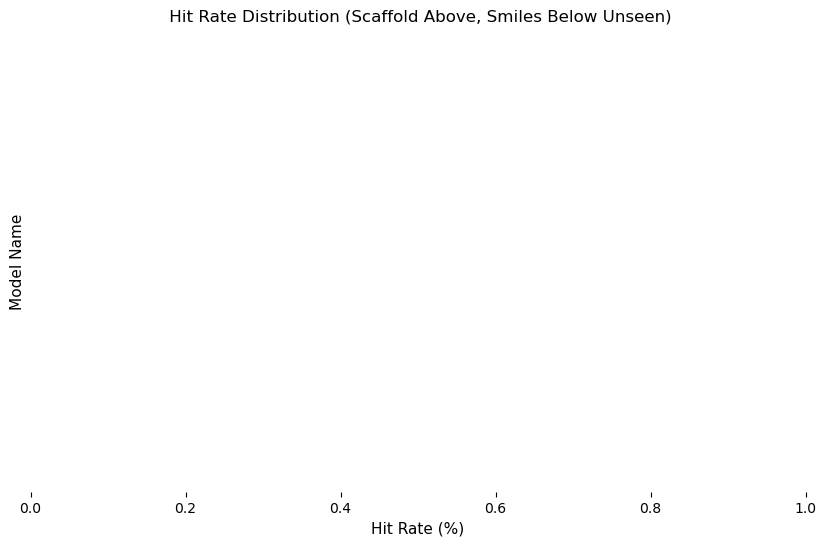

In [15]:
from scipy.stats import gaussian_kde

# Create ridge plotriables based on the context
fig, ax = plt.subplots(figsize=(10, 6))
data_plot = data_mean_from_uniprot_unseen.reset_index()
model_order = data_plot.groupby('ModelName')['Finded_Scaffold_Hit_Rate(%)'].mean().sort_values(ascending=True).index
# Prepare data for ridge plot
ridge_spacing = 1.0  # Vertical spacing between ridges
y_positions = np.arange(len(model_order)) * ridge_spacing
scaffold_data = [data_mean_from_uniprot_unseen.loc[model]['Finded_Scaffold_Hit_Rate(%)'].values for model in model_order]
smiles_data = [data_mean_from_uniprot_unseen.loc[model]['Finded_Smiles_Hit_Rate(%)'].values for model in model_order]
# Create ridge plot for both scaffold and smiles data
for i, model in enumerate(model_order):
    y_base = y_positions[i]
    
    # Get data for current model
    scaffold_values = scaffold_data[i]
    smiles_values = smiles_data[i]
    
    # Create density plots using kernel density estimation
    
    # Scaffold density
    if len(scaffold_values) > 1 and np.std(scaffold_values) > 0:
        kde_scaffold = gaussian_kde(scaffold_values)
        x_range = np.linspace(scaffold_values.min() - 1, scaffold_values.max() + 1, 200)
        density_scaffold = kde_scaffold(x_range)
        # Normalize and scale density
        density_scaffold = density_scaffold / density_scaffold.max() * 0.35
    else:
        x_range = np.linspace(-1, max(scaffold_values) + 1, 200)
        density_scaffold = np.zeros_like(x_range)
    
    # Smiles density  
    if len(smiles_values) > 1 and np.std(smiles_values) > 0:
        kde_smiles = gaussian_kde(smiles_values)
        density_smiles = kde_smiles(x_range)
        # Normalize and scale density
        density_smiles = density_smiles / density_smiles.max() * 0.35
    else:
        density_smiles = np.zeros_like(x_range)
    
    # Plot scaffold ridge (upper half)
    ax.fill_between(x_range, y_base, y_base + density_scaffold, 
                   alpha=0.6, color=color_map[model], label='Scaffold' if i == 0 else "")
    ax.plot(x_range, y_base + density_scaffold, color=color_map[model], linewidth=1)
    
    # Plot smiles ridge (lower half)
    ax.fill_between(x_range, y_base, y_base - density_smiles, 
                   alpha=0.6, color=color_map[model], label='Smiles' if i == 0 else "")
    ax.plot(x_range, y_base - density_smiles, color=color_map[model], linewidth=1)
    # 
    # Add baseline
    ax.axhline(y=y_base, color='gray', alpha=0.3, linewidth=0.5)
    
    # Add mean markers
    scaffold_mean = np.mean(scaffold_values)
    smiles_mean = np.mean(smiles_values)
    
    ax.scatter(scaffold_mean, y_base + 0.1, marker='^', s=80, 
              facecolors='white', edgecolors=color_map[model], linewidths=1.5, zorder=5)
    ax.scatter(smiles_mean, y_base - 0.1, marker='v', s=80, 
              facecolors='white', edgecolors=color_map[model], linewidths=1.5, zorder=5)
    
    # Add some sample points as small dots
    np.random.seed(42)
    scaffold_jitter = np.random.normal(0, 0.02, len(scaffold_values))
    smiles_jitter = np.random.normal(0, 0.02, len(smiles_values))
    
    ax.scatter(scaffold_values, y_base + 0.1 + scaffold_jitter, 
              alpha=0.4, s=8, color=color_map[model], zorder=3)
    ax.scatter(smiles_values, y_base - 0.1 + smiles_jitter, 
              alpha=0.4, s=8, color=color_map[model], zorder=3)

# Remove spines/frame
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Customize the plot
ax.set_yticks(y_positions)
ax.set_yticklabels(model_order, fontsize=10, ha='right')
ax.set_xlabel('Hit Rate (%)', fontsize=11)
ax.set_ylabel('Model Name', fontsize=11)
ax.set_title(' Hit Rate Distribution (Scaffold Above, Smiles Below Unseen)', fontsize=12)

# Add legend with better alignment
# legend_elements = [
#     plt.Line2D([0], [0], color='gray', alpha=0.7, linewidth=3, label='Scaffold'),
#     plt.Line2D([0], [0], color='gray', alpha=0.5, linewidth=3, label='Smiles'),
#     plt.Line2D([0], [0], marker='^', color='w', markerfacecolor='white', 
#                markeredgecolor='black', markersize=8, label='Scaffold Mean'),
#     plt.Line2D([0], [0], marker='v', color='w', markerfacecolor='white', 
#                markeredgecolor='black', markersize=8, label='Smiles Mean')
# ]
# ax.legend(handles=legend_elements, loc='upper right', fontsize=9, frameon=False)

# Set limits and grid
ax.set_xlim(-5, max([max(scaffold_data[i]) for i in range(len(model_order))] + 
                   [max(smiles_data[i]) for i in range(len(model_order))]) + 5)
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()

plt.savefig('/home/data-house-01/cdhofficial/MolGens/TestSample_H2L/Round1/Hit_to_Lead_Results/hit2lead_hit_rate_unseen_protein.svg',bbox_inches='tight',dpi=660,format='svg')
# plt.show()
plt.show()

ValueError: max() arg is an empty sequence

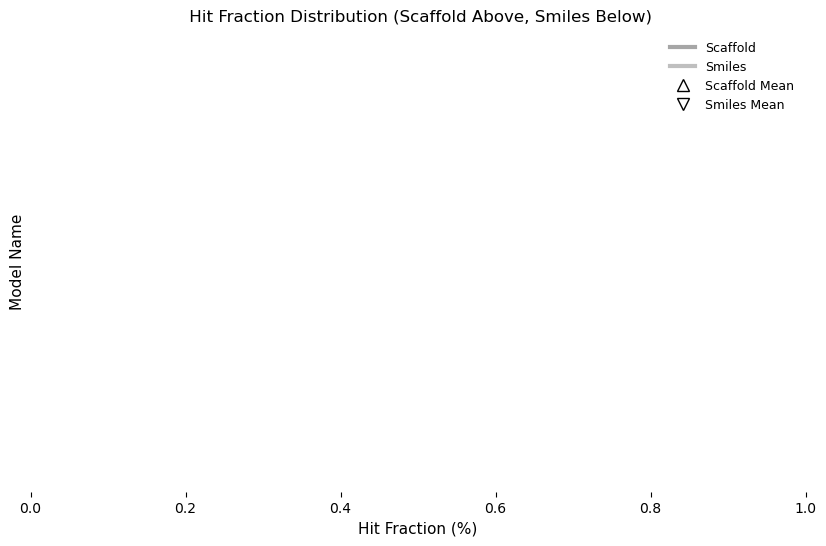

In [ ]:
from scipy.stats import gaussian_kde

# Create ridge plotriables based on the context
fig, ax = plt.subplots(figsize=(10, 6))

data_plot = data_mean_from_uniprot_unseen.reset_index()
model_order = data_plot.groupby('ModelName')['Finded_Scaffold_Hit_Rate(%)'].mean().sort_values(ascending=True).index
# Prepare data for ridge plot
ridge_spacing = 1.0  # Vertical spacing between ridges
y_positions = np.arange(len(model_order)) * ridge_spacing
scaffold_data = [data_mean_from_uniprot_unseen.loc[model]['Finded_Scaffold_Hit_Rate(%)'].values for model in model_order]
smiles_data = [data_mean_from_uniprot_unseen.loc[model]['Finded_Smiles_Hit_Rate(%)'].values for model in model_order]
# Create ridge plot for both scaffold and smiles data
for i, model in enumerate(model_order):
    y_base = y_positions[i]
    
    # Get data for current model
    scaffold_values = scaffold_data[i]
    smiles_values = smiles_data[i]
    
    # Create density plots using kernel density estimation
    
    # Scaffold density
    if len(scaffold_values) > 1 and np.std(scaffold_values) > 0:
        kde_scaffold = gaussian_kde(scaffold_values)
        x_range = np.linspace(scaffold_values.min() - 1, scaffold_values.max() + 1, 200)
        density_scaffold = kde_scaffold(x_range)
        # Normalize and scale density
        density_scaffold = density_scaffold / density_scaffold.max() * 0.35
    else:
        x_range = np.linspace(-1, max(scaffold_values) + 1, 200)
        density_scaffold = np.zeros_like(x_range)
    
    # Smiles density  
    if len(smiles_values) > 1 and np.std(smiles_values) > 0:
        kde_smiles = gaussian_kde(smiles_values)
        density_smiles = kde_smiles(x_range)
        # Normalize and scale density
        density_smiles = density_smiles / density_smiles.max() * 0.35
    else:
        density_smiles = np.zeros_like(x_range)
    
    # Plot scaffold ridge (upper half)
    ax.fill_between(x_range, y_base, y_base + density_scaffold, 
                   alpha=0.6, color=color_map[model], label='Scaffold' if i == 0 else "")
    ax.plot(x_range, y_base + density_scaffold, color=color_map[model], linewidth=1)
    
    # Plot smiles ridge (lower half)
    ax.fill_between(x_range, y_base, y_base - density_smiles, 
                   alpha=0.6, color=color_map[model], label='Smiles' if i == 0 else "")
    ax.plot(x_range, y_base - density_smiles, color=color_map[model], linewidth=1)
    # 
    # Add baseline
    ax.axhline(y=y_base, color='gray', alpha=0.3, linewidth=0.5)
    
    # Add mean markers
    scaffold_mean = np.mean(scaffold_values)
    smiles_mean = np.mean(smiles_values)
    
    ax.scatter(scaffold_mean, y_base + 0.1, marker='^', s=80, 
              facecolors='white', edgecolors=color_map[model], linewidths=1.5, zorder=5)
    ax.scatter(smiles_mean, y_base - 0.1, marker='v', s=80, 
              facecolors='white', edgecolors=color_map[model], linewidths=1.5, zorder=5)
    
    # Add some sample points as small dots
    np.random.seed(42)
    scaffold_jitter = np.random.normal(0, 0.02, len(scaffold_values))
    smiles_jitter = np.random.normal(0, 0.02, len(smiles_values))
    
    ax.scatter(scaffold_values, y_base + 0.1 + scaffold_jitter, 
              alpha=0.4, s=8, color=color_map[model], zorder=3)
    ax.scatter(smiles_values, y_base - 0.1 + smiles_jitter, 
              alpha=0.4, s=8, color=color_map[model], zorder=3)
    # Add mean value text labels
    ax.text(scaffold_mean, y_base + 0.3, f'{scaffold_mean:.3f}', 
           ha='center', va='bottom', fontsize=8, color=color_map[model], fontweight='bold')
    ax.text(smiles_mean, y_base - 0.3, f'{smiles_mean:.3f}', 
           ha='center', va='top', fontsize=8, color=color_map[model], fontweight='bold')
    
# Remove spines/frame
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Customize the plot
ax.set_yticks(y_positions)
ax.set_yticklabels(model_order, fontsize=10, ha='right')
ax.set_xlabel('Hit  Rate (%)', fontsize=11)
ax.set_ylabel('Model Name', fontsize=11)
ax.set_title(' Hit Rate Distribution (Scaffold Above, Smiles Below)', fontsize=12)

# Add legend with better alignment
legend_elements = [
    plt.Line2D([0], [0], color='gray', alpha=0.7, linewidth=3, label='Scaffold'),
    plt.Line2D([0], [0], color='gray', alpha=0.5, linewidth=3, label='Smiles'),
    plt.Line2D([0], [0], marker='^', color='w', markerfacecolor='white', 
               markeredgecolor='black', markersize=8, label='Scaffold Mean'),
    plt.Line2D([0], [0], marker='v', color='w', markerfacecolor='white', 
               markeredgecolor='black', markersize=8, label='Smiles Mean')
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=9, frameon=False)

# Set limits and grid
ax.set_xlim(-5, max([max(scaffold_data[i]) for i in range(len(model_order))] + 
                   [max(smiles_data[i]) for i in range(len(model_order))]) + 5)
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()

plt.savefig('/home/data-house-01/cdhofficial/MolGens/TestSample_H2L/Round1/Hit_to_Lead_Results/hit2lead_hit_rate_unseen_protein_with_mean_value.svg',bbox_inches='tight',dpi=660,format='svg')
# plt.show()
plt.show()

## seen proteins

In [17]:
data_mean_from_uniprot_seen = data_mean_from_uniprot.reset_index()
data_mean_from_uniprot_seen['seen'] = data_mean_from_uniprot_seen['UniprotID'].apply(lambda x: x.split('_')[0] in UniprotId_in_crossdock)
data_mean_from_uniprot_seen = data_mean_from_uniprot_seen[data_mean_from_uniprot_seen['seen']]
data_mean_from_uniprot_seen=data_mean_from_uniprot_seen.groupby(['ModelName','UniprotID']).agg('mean')

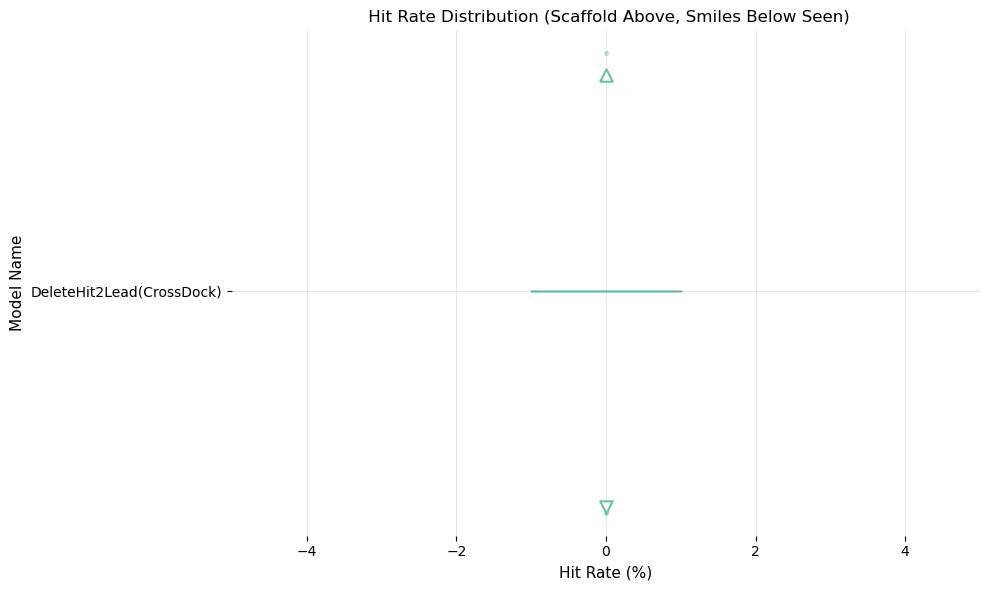

In [18]:
from scipy.stats import gaussian_kde

# Create ridge plotriables based on the context
fig, ax = plt.subplots(figsize=(10, 6))
data_plot = data_mean_from_uniprot_seen.reset_index()
model_order = data_plot.groupby('ModelName')['Finded_Scaffold_Hit_Rate(%)'].mean().sort_values(ascending=True).index
# Prepare data for ridge plot
ridge_spacing = 1.0  # Vertical spacing between ridges
y_positions = np.arange(len(model_order)) * ridge_spacing
scaffold_data = [data_mean_from_uniprot_seen.loc[model]['Finded_Scaffold_Hit_Rate(%)'].values for model in model_order]
smiles_data = [data_mean_from_uniprot_seen.loc[model]['Finded_Smiles_Hit_Rate(%)'].values for model in model_order]
# Create ridge plot for both scaffold and smiles data
for i, model in enumerate(model_order):
    y_base = y_positions[i]
    
    # Get data for current model
    scaffold_values = scaffold_data[i]
    smiles_values = smiles_data[i]
    
    # Create density plots using kernel density estimation
    
    # Scaffold density
    if len(scaffold_values) > 1 and np.std(scaffold_values) > 0:
        kde_scaffold = gaussian_kde(scaffold_values)
        x_range = np.linspace(scaffold_values.min() - 1, scaffold_values.max() + 1, 200)
        density_scaffold = kde_scaffold(x_range)
        # Normalize and scale density
        density_scaffold = density_scaffold / density_scaffold.max() * 0.35
    else:
        x_range = np.linspace(-1, max(scaffold_values) + 1, 200)
        density_scaffold = np.zeros_like(x_range)
    
    # Smiles density  
    if len(smiles_values) > 1 and np.std(smiles_values) > 0:
        kde_smiles = gaussian_kde(smiles_values)
        density_smiles = kde_smiles(x_range)
        # Normalize and scale density
        density_smiles = density_smiles / density_smiles.max() * 0.35
    else:
        density_smiles = np.zeros_like(x_range)
    
    # Plot scaffold ridge (upper half)
    ax.fill_between(x_range, y_base, y_base + density_scaffold, 
                   alpha=0.6, color=color_map[model], label='Scaffold' if i == 0 else "")
    ax.plot(x_range, y_base + density_scaffold, color=color_map[model], linewidth=1)
    
    # Plot smiles ridge (lower half)
    ax.fill_between(x_range, y_base, y_base - density_smiles, 
                   alpha=0.6, color=color_map[model], label='Smiles' if i == 0 else "")
    ax.plot(x_range, y_base - density_smiles, color=color_map[model], linewidth=1)
    # 
    # Add baseline
    ax.axhline(y=y_base, color='gray', alpha=0.3, linewidth=0.5)
    
    # Add mean markers
    scaffold_mean = np.mean(scaffold_values)
    smiles_mean = np.mean(smiles_values)
    
    ax.scatter(scaffold_mean, y_base + 0.1, marker='^', s=80, 
              facecolors='white', edgecolors=color_map[model], linewidths=1.5, zorder=5)
    ax.scatter(smiles_mean, y_base - 0.1, marker='v', s=80, 
              facecolors='white', edgecolors=color_map[model], linewidths=1.5, zorder=5)
    
    # Add some sample points as small dots
    np.random.seed(42)
    scaffold_jitter = np.random.normal(0, 0.02, len(scaffold_values))
    smiles_jitter = np.random.normal(0, 0.02, len(smiles_values))
    
    ax.scatter(scaffold_values, y_base + 0.1 + scaffold_jitter, 
              alpha=0.4, s=8, color=color_map[model], zorder=3)
    ax.scatter(smiles_values, y_base - 0.1 + smiles_jitter, 
              alpha=0.4, s=8, color=color_map[model], zorder=3)

# Remove spines/frame
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Customize the plot
ax.set_yticks(y_positions)
ax.set_yticklabels(model_order, fontsize=10, ha='right')
ax.set_xlabel('Hit Rate (%)', fontsize=11)
ax.set_ylabel('Model Name', fontsize=11)
ax.set_title(' Hit Rate Distribution (Scaffold Above, Smiles Below Seen)', fontsize=12)

# # Add legend with better alignment
# legend_elements = [
#     plt.Line2D([0], [0], color='gray', alpha=0.7, linewidth=3, label='Scaffold'),
#     plt.Line2D([0], [0], color='gray', alpha=0.5, linewidth=3, label='Smiles'),
#     plt.Line2D([0], [0], marker='^', color='w', markerfacecolor='white', 
#                markeredgecolor='black', markersize=8, label='Scaffold Mean'),
#     plt.Line2D([0], [0], marker='v', color='w', markerfacecolor='white', 
#                markeredgecolor='black', markersize=8, label='Smiles Mean')
# ]
# ax.legend(handles=legend_elements, loc='upper right', fontsize=9, frameon=False)

# Set limits and grid
ax.set_xlim(-5, max([max(scaffold_data[i]) for i in range(len(model_order))] + 
                   [max(smiles_data[i]) for i in range(len(model_order))]) + 5)
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()

plt.savefig('/home/data-house-01/cdhofficial/MolGens/TestSample_H2L/Round1/Hit_to_Lead_Results/hit2lead_hit_rate_seen_protein.svg',bbox_inches='tight',dpi=660,format='svg')
# plt.show()
plt.show()

/tmp/ipykernel_617821/988310579.py:109: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


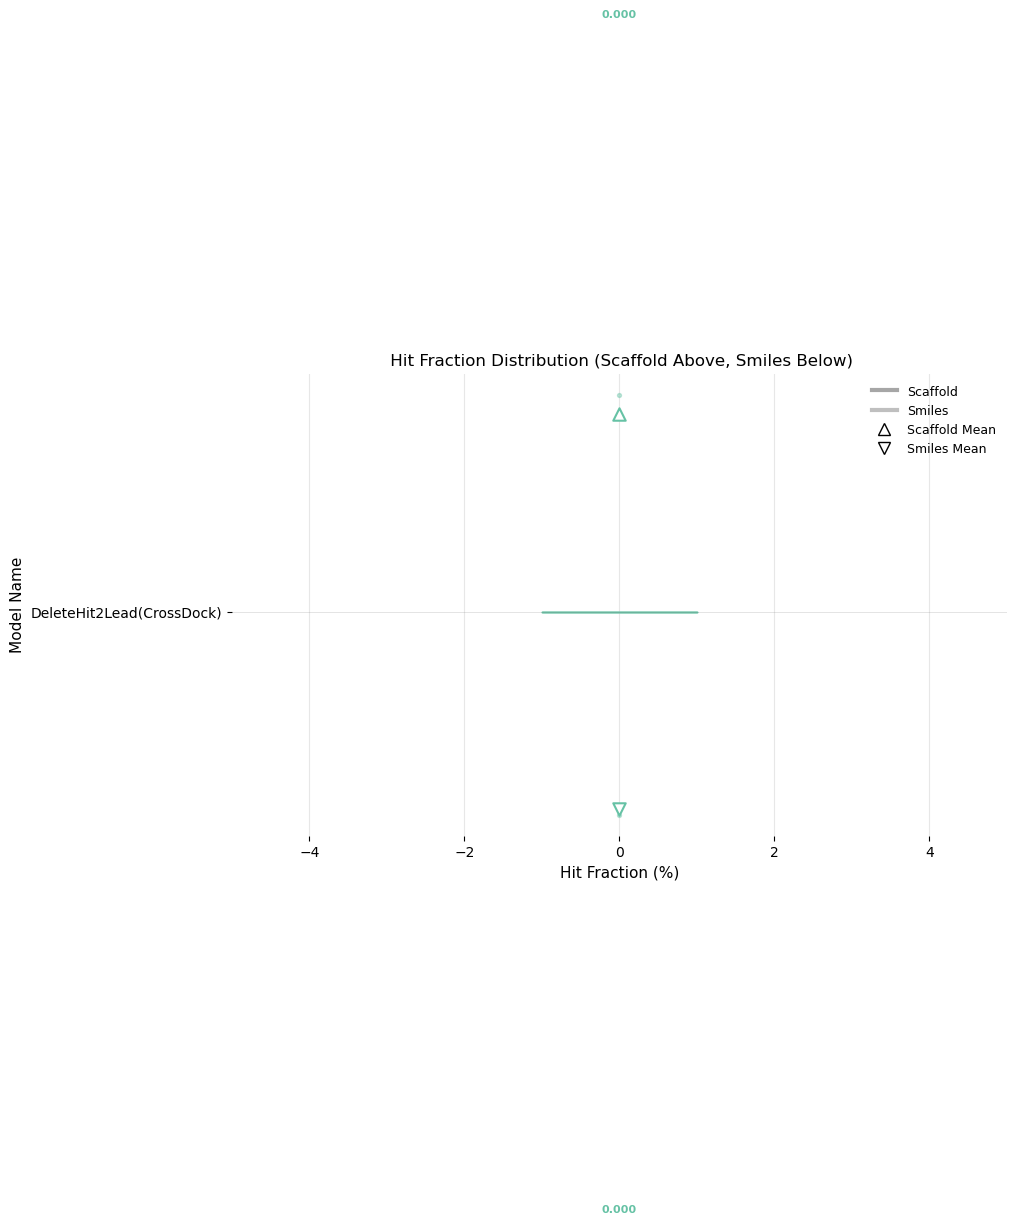

In [19]:
from scipy.stats import gaussian_kde

# Create ridge plotriables based on the context
fig, ax = plt.subplots(figsize=(10, 6))

data_plot = data_mean_from_uniprot_seen.reset_index()
model_order = data_plot.groupby('ModelName')['Finded_Scaffold_Hit_Rate(%)'].mean().sort_values(ascending=True).index
# Prepare data for ridge plot
ridge_spacing = 1.0  # Vertical spacing between ridges
y_positions = np.arange(len(model_order)) * ridge_spacing
scaffold_data = [data_mean_from_uniprot_seen.loc[model]['Finded_Scaffold_Hit_Rate(%)'].values for model in model_order]
smiles_data = [data_mean_from_uniprot_seen.loc[model]['Finded_Smiles_Hit_Rate(%)'].values for model in model_order]
# Create ridge plot for both scaffold and smiles data
for i, model in enumerate(model_order):
    y_base = y_positions[i]
    
    # Get data for current model
    scaffold_values = scaffold_data[i]
    smiles_values = smiles_data[i]
    
    # Create density plots using kernel density estimation
    
    # Scaffold density
    if len(scaffold_values) > 1 and np.std(scaffold_values) > 0:
        kde_scaffold = gaussian_kde(scaffold_values)
        x_range = np.linspace(scaffold_values.min() - 1, scaffold_values.max() + 1, 200)
        density_scaffold = kde_scaffold(x_range)
        # Normalize and scale density
        density_scaffold = density_scaffold / density_scaffold.max() * 0.35
    else:
        x_range = np.linspace(-1, max(scaffold_values) + 1, 200)
        density_scaffold = np.zeros_like(x_range)
    
    # Smiles density  
    if len(smiles_values) > 1 and np.std(smiles_values) > 0:
        kde_smiles = gaussian_kde(smiles_values)
        density_smiles = kde_smiles(x_range)
        # Normalize and scale density
        density_smiles = density_smiles / density_smiles.max() * 0.35
    else:
        density_smiles = np.zeros_like(x_range)
    
    # Plot scaffold ridge (upper half)
    ax.fill_between(x_range, y_base, y_base + density_scaffold, 
                   alpha=0.6, color=color_map[model], label='Scaffold' if i == 0 else "")
    ax.plot(x_range, y_base + density_scaffold, color=color_map[model], linewidth=1)
    
    # Plot smiles ridge (lower half)
    ax.fill_between(x_range, y_base, y_base - density_smiles, 
                   alpha=0.6, color=color_map[model], label='Smiles' if i == 0 else "")
    ax.plot(x_range, y_base - density_smiles, color=color_map[model], linewidth=1)
    # 
    # Add baseline
    ax.axhline(y=y_base, color='gray', alpha=0.3, linewidth=0.5)
    
    # Add mean markers
    scaffold_mean = np.mean(scaffold_values)
    smiles_mean = np.mean(smiles_values)
    
    ax.scatter(scaffold_mean, y_base + 0.1, marker='^', s=80, 
              facecolors='white', edgecolors=color_map[model], linewidths=1.5, zorder=5)
    ax.scatter(smiles_mean, y_base - 0.1, marker='v', s=80, 
              facecolors='white', edgecolors=color_map[model], linewidths=1.5, zorder=5)
    
    # Add some sample points as small dots
    np.random.seed(42)
    scaffold_jitter = np.random.normal(0, 0.02, len(scaffold_values))
    smiles_jitter = np.random.normal(0, 0.02, len(smiles_values))
    
    ax.scatter(scaffold_values, y_base + 0.1 + scaffold_jitter, 
              alpha=0.4, s=8, color=color_map[model], zorder=3)
    ax.scatter(smiles_values, y_base - 0.1 + smiles_jitter, 
              alpha=0.4, s=8, color=color_map[model], zorder=3)
    # Add mean value text labels
    ax.text(scaffold_mean, y_base + 0.3, f'{scaffold_mean:.3f}', 
           ha='center', va='bottom', fontsize=8, color=color_map[model], fontweight='bold')
    ax.text(smiles_mean, y_base - 0.3, f'{smiles_mean:.3f}', 
           ha='center', va='top', fontsize=8, color=color_map[model], fontweight='bold')
    
# Remove spines/frame
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Customize the plot
ax.set_yticks(y_positions)
ax.set_yticklabels(model_order, fontsize=10, ha='right')
ax.set_xlabel('Hit Fraction (%)', fontsize=11)
ax.set_ylabel('Model Name', fontsize=11)
ax.set_title(' Hit Fraction Distribution (Scaffold Above, Smiles Below)', fontsize=12)

# Add legend with better alignment
legend_elements = [
    plt.Line2D([0], [0], color='gray', alpha=0.7, linewidth=3, label='Scaffold'),
    plt.Line2D([0], [0], color='gray', alpha=0.5, linewidth=3, label='Smiles'),
    plt.Line2D([0], [0], marker='^', color='w', markerfacecolor='white', 
               markeredgecolor='black', markersize=8, label='Scaffold Mean'),
    plt.Line2D([0], [0], marker='v', color='w', markerfacecolor='white', 
               markeredgecolor='black', markersize=8, label='Smiles Mean')
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=9, frameon=False)

# Set limits and grid
ax.set_xlim(-5, max([max(scaffold_data[i]) for i in range(len(model_order))] + 
                   [max(smiles_data[i]) for i in range(len(model_order))]) + 5)
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()

plt.savefig('/home/data-house-01/cdhofficial/MolGens/TestSample_H2L/Round1/Hit_to_Lead_Results/hit2lead_hit_rate_seen_protein_with_mean_value.svg',bbox_inches='tight',dpi=660,format='svg')
# plt.show()
plt.show()